# Phase 3: Clean Data Exploratory Analysis (Clean EDA)

**Goal**: Validate "Gold Layer" Features & Business Hypotheses.

**Objectives**:
1.  **Feature Normality**: Check signal distributions (Critical for Deep Learning).
2.  **Quality Landscape**: Define "Suboptimal" vs "Optimal" batches (Safety Margins).
3.  **Correlations**: Validate if `Physical Variability` -> `Quality Issues`.
4.  **Drift**: Assess process stability over Campaigns.

**Note**: This notebook uses the Gold Layer data (`s3a://gold`).


In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.ml.functions import vector_to_array

# Add src to path
sys.path.append(os.path.abspath('../src'))
from config import get_spark_session, get_data_path

# Initialize Spark
spark = get_spark_session("Clean_EDA_Notebook")
gold_path = get_data_path("gold")


🔧 Configuring specific S3 endpoint for MinIO: http://minio:9000
:: loading settings :: url = jar:file:/usr/local/lib/python3.11/dist-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8224fbea-e9a6-4efa-8f08-e61fdd48d182;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
:: resolution report :: resolve 189ms :: artifacts dl 5ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.12.262 from central in [default]
	org.apache.hadoop#hadoop-aws;3.3.4 from central in [default]
	org.wildfly.openssl#wildfly-openssl;1.0.7.Final from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|d

## 1. Load Gold Data
Loading Train/Test splits and the Batch Summary table.


In [2]:
df_train = spark.read.parquet(f"{gold_path}/Train")
df_test = spark.read.parquet(f"{gold_path}/Test")
df_summary = spark.read.parquet(f"{gold_path}/Batch_Summary")

# print(f"Train Rows: {df_train.count()}")
# print(f"Test Rows: {df_test.count()}")
print(f"Batch Summary Rows: {df_summary.count()}")


26/01/22 12:21:49 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
[Stage 5:=======================================>                   (4 + 2) / 6]

Batch Summary Rows: 1005


## 2. Feature Distributions (Normality Check)
Deep Learning (Autoencoders) assumes input features are roughly Gaussian (Mean=0, Std=1).
We scaled them in the previous step. Let's verify.


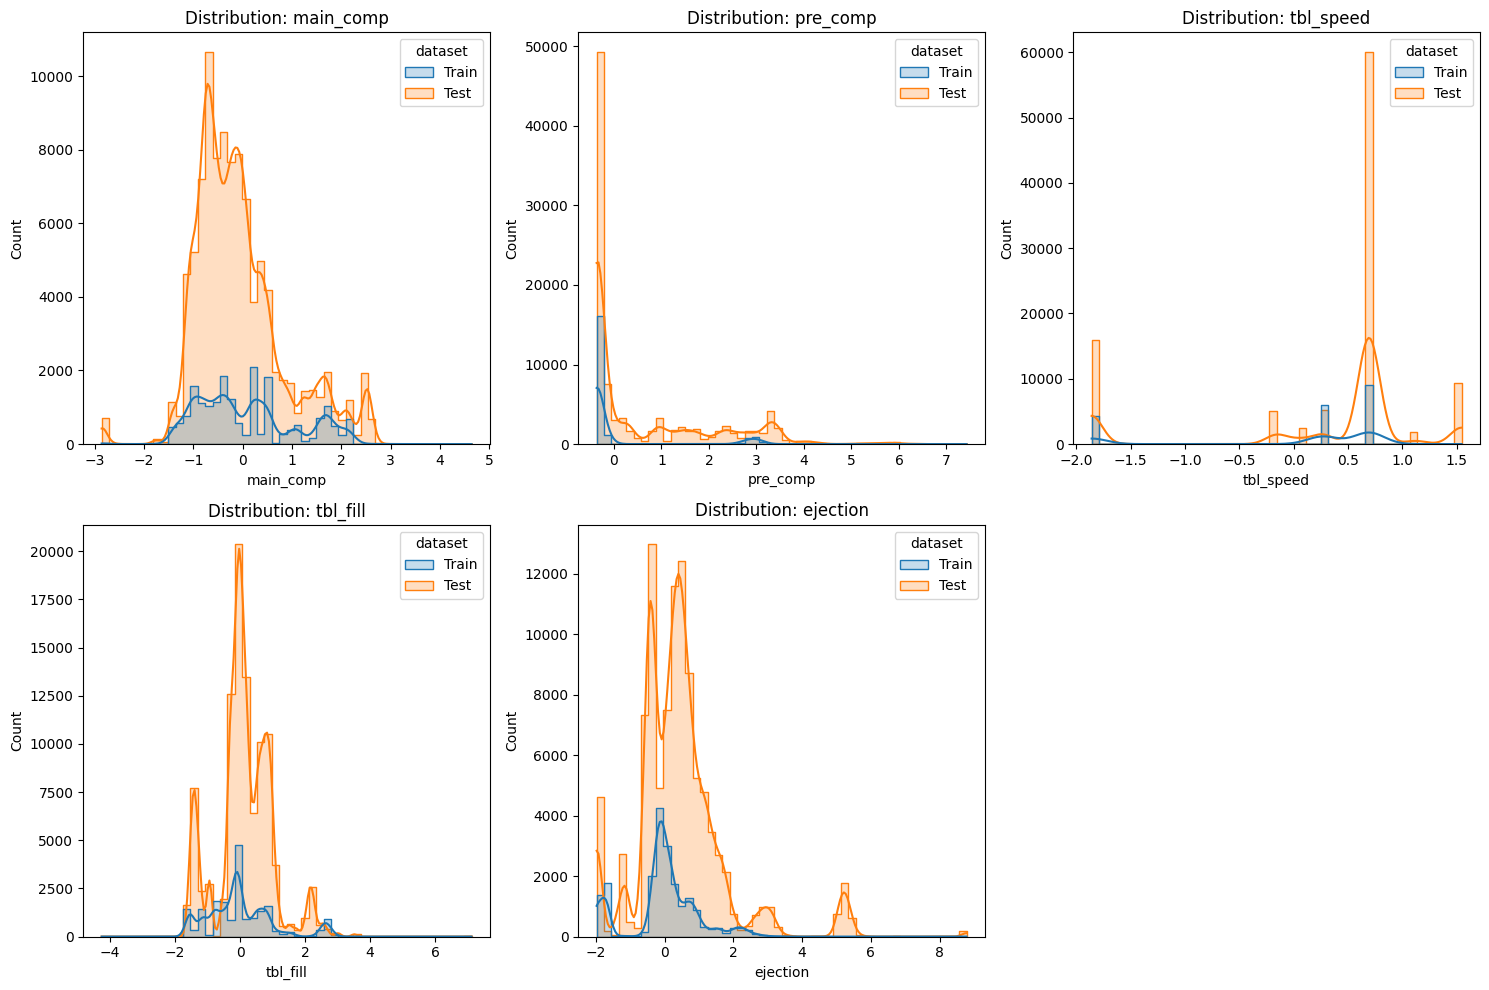

In [3]:
# Helper to unpack vector
sensor_cols = ["main_comp", "pre_comp", "tbl_speed", "tbl_fill", "ejection"]

def unpack_features(df, sample_frac=0.1):
    df_sample = df.sample(fraction=sample_frac, seed=42).limit(100000)
    return df_sample.select(vector_to_array("features_scaled").alias("feats")).select(
        [F.col("feats")[i].alias(c) for i, c in enumerate(sensor_cols)]
    ).toPandas()

pdf_train = unpack_features(df_train, sample_frac=0.05)
pdf_test = unpack_features(df_test, sample_frac=0.05)
pdf_train["dataset"] = "Train"
pdf_test["dataset"] = "Test"
pdf_all = pd.concat([pdf_train, pdf_test], ignore_index=True)

plt.figure(figsize=(15, 10))
for i, col in enumerate(sensor_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=pdf_all, x=col, hue="dataset", bins=50, kde=True, element="step", common_norm=False)
    plt.title(f"Distribution: {col}")
plt.tight_layout()
plt.show()


## 3. Quality Landscape (Defining Targets)
Since we don't have "Bad Batches" (all passed QC), we define **Warning Zones**.
*   **Dissolution Limit**: 75% (Legal).
*   **Internal Warning**: < 80%?


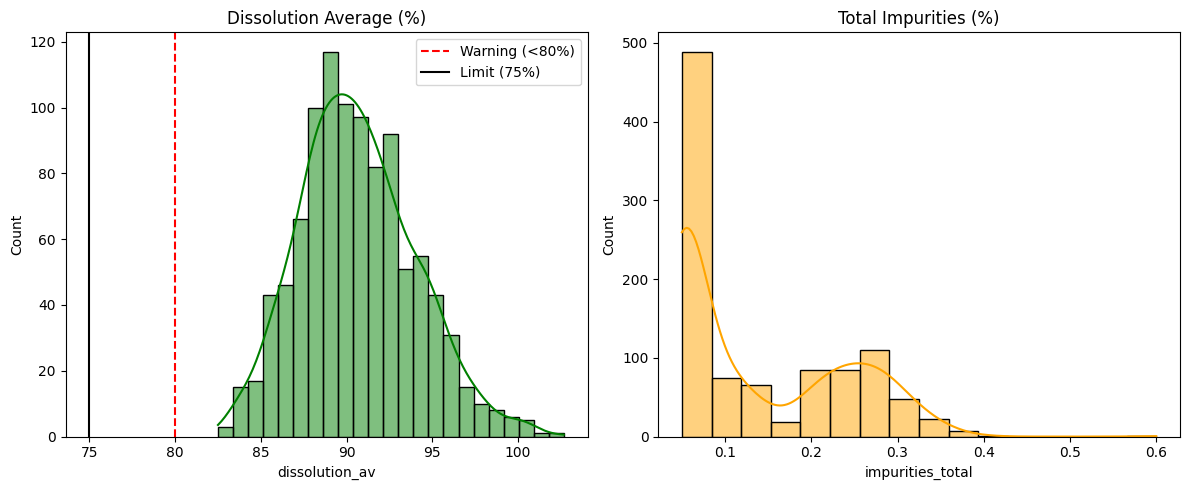

In [4]:
pdf_summary = df_summary.select("dissolution_av", "impurities_total", "variability_main_comp", "campaign").toPandas()

plt.figure(figsize=(12, 5))

# Dissolution
plt.subplot(1, 2, 1)
sns.histplot(pdf_summary["dissolution_av"], kde=True, color="green")
plt.axvline(80, color='red', linestyle='--', label='Warning (<80%)')
plt.axvline(75, color='black', linestyle='-', label='Limit (75%)')
plt.title("Dissolution Average (%)")
plt.legend()

# Impurities
plt.subplot(1, 2, 2)
sns.histplot(pdf_summary["impurities_total"], kde=True, color="orange")
plt.title("Total Impurities (%)")

plt.tight_layout()
plt.show()


## 4. Business Correlations
Hypothesis: High Variability in Compression -> Lower Dissolution?


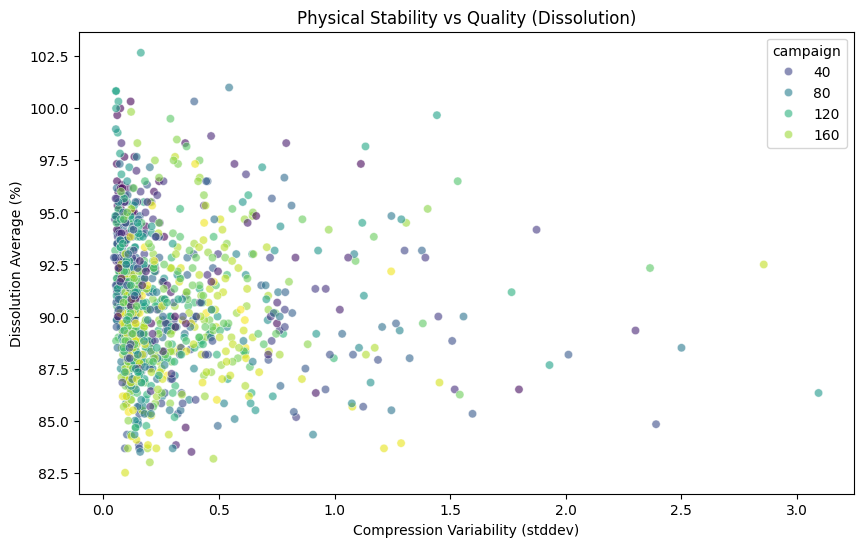

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pdf_summary, x="variability_main_comp", y="dissolution_av", hue="campaign", alpha=0.6, palette="viridis")
plt.title("Physical Stability vs Quality (Dissolution)")
plt.xlabel("Compression Variability (stddev)")
plt.ylabel("Dissolution Average (%)")
plt.show()


## 5. Drift Analysis
Does the process drift over time (Campaigns)?


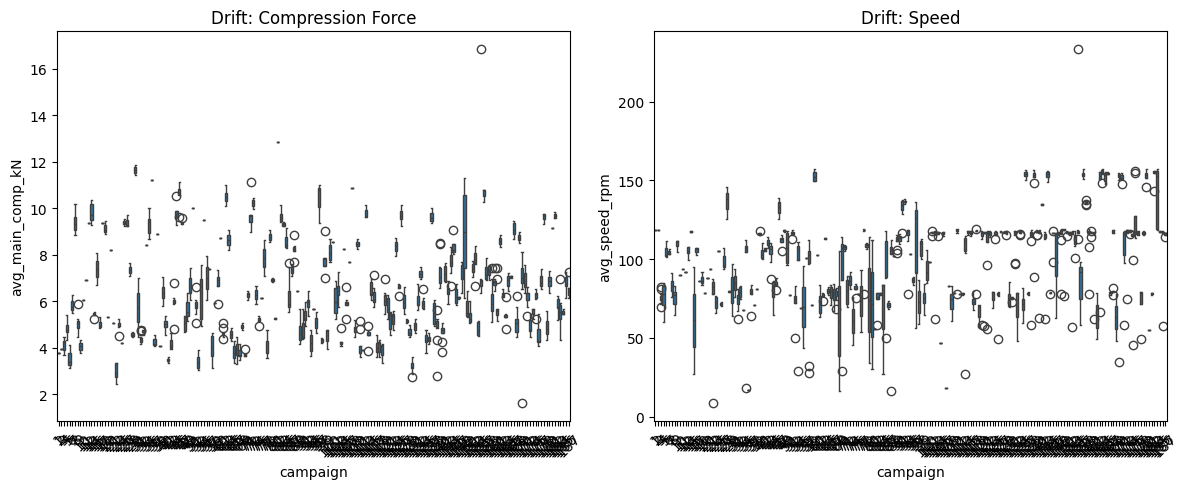

In [6]:
# Using aggregated metrics as proxy for drift
pdf_drift = df_summary.select("campaign", "avg_main_comp_kN", "avg_speed_rpm").toPandas()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=pdf_drift, x="campaign", y="avg_main_comp_kN")
plt.title("Drift: Compression Force")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(data=pdf_drift, x="campaign", y="avg_speed_rpm")
plt.title("Drift: Speed")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
